# Técnicas de Regresión para predicción de Costo de Casas



## Obtención de Datos

In [1]:
# Importación de librerías
import numpy as np
import pandas as pd

# Carga de csv con datos de entrenamiento
train = pd.read_csv('./data/train.csv')
train.head(n=10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


## Exploración de Datos

In [2]:
# Resumen estadístico descriptivo excluyendo valores NaN
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[10, 14, 0, 180]

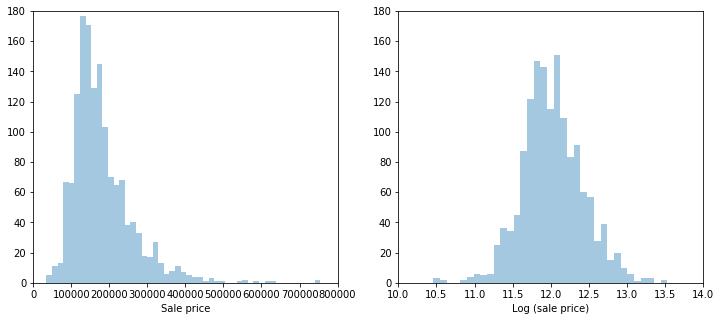

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Setup de figuras de Matploplib
plt.figure(figsize=(12,5))
#f, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Primer gráfico de distribución de Precios de Venta
plt.subplot(121)
sns.distplot(train['SalePrice'],kde=False)
plt.xlabel('Sale price')
plt.axis([0,800000,0,180])

# Segundo gráfico de distribución de Logaritmo de Precios de Venta
plt.subplot(122)
sns.distplot(np.log(train['SalePrice']),kde=False)
plt.xlabel('Log (sale price)')
plt.axis([10,14,0,180])

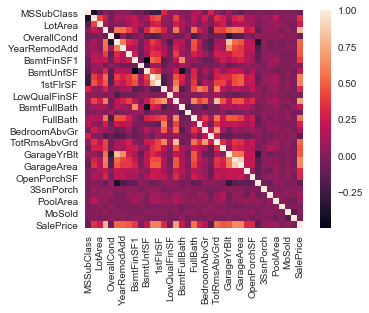

In [4]:
# Mapa de Correlaciones
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()

sns.set(font_scale=1)  
sns.heatmap(corr, vmax=1, square=True)

In [14]:
# Lista de variables más correlacionadas con el Precio de Venta
corr_list = corr['SalePrice'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list.head(n=10)

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

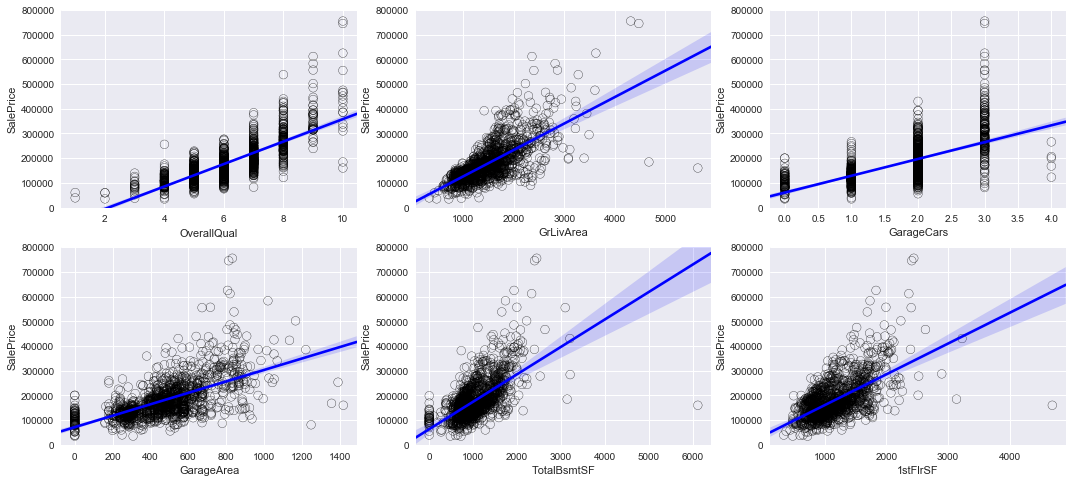

In [6]:
# Ploteo de Características más correlacionadas Vs el Precio de Venta
plt.figure(figsize=(18,8))
for i in range(6):
    ii = '23'+str(i+1)
    plt.subplot(ii)
    feature = corr_list.index.values[i]
    plt.scatter(train[feature], train['SalePrice'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'SalePrice', data = train,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,800000])


## Preprocesamiento

In [9]:

def data_preprocess(train,test):
    from scipy.stats import skew
    import pandas as pd
    outlier_idx = [4,11,13,20,46,66,70,167,178,185,199, 224,261, 309,313,318, 349,412,423,440,454,477,478, 523,540, 581,588,595,654,688, 691, 774, 798, 875, 898,926,970,987,1027,1109, 1169,1182,1239, 1256,1298,1324,1353,1359,1405,1442,1447]
    train.drop(train.index[outlier_idx],inplace=True)
    all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                          test.loc[:,'MSSubClass':'SaleCondition']))
    
    to_delete = ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature']
    all_data = all_data.drop(to_delete,axis=1)

    train["SalePrice"] = np.log1p(train["SalePrice"])
    #log transform skewed numeric features
    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
    skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index
    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
    all_data = pd.get_dummies(all_data)
    all_data = all_data.fillna(all_data.mean())
    X_train = all_data[:train.shape[0]]
    X_test = all_data[train.shape[0]:]
    y = train.SalePrice

    return X_train,X_test,y


train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
print("Data preprocessing ...")
Xtrain,Xtest,ytrain = data_preprocess(train,test)
print("Data preprocessed!")

Data preprocessing ...
Data preprocessed!


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log1p


## Models

In [10]:
from models.base import *

#test_predict,score = model_random_forecast(Xtrain,Xtest,ytrain)
#test_predict,score = model_extra_trees_regression(Xtrain,Xtest,ytrain)
test_predict,score = model_gradient_boosting_tree(Xtrain,Xtest,ytrain)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Gradient boosted tree regression...
Best Params:
{}
Best CV Score:
0.11298975443406793


## Submission

In [11]:
import numpy as np
import datetime
import pandas as pd
def create_submission(prediction,score,test):
    now = datetime.datetime.now()
    sub_file = 'submission_'+str(score)+'_'+str(now.strftime("%Y-%m-%d-%H-%M"))+'.csv'
    print ('Creating submission: ', sub_file)
    pd.DataFrame({'Id': test['Id'].values, 'SalePrice': prediction}).to_csv(sub_file, index=False)
    print ('Submission created!')

create_submission(np.exp(test_predict),score,test)

Creating submission:  submission_0.11298975443406793_2018-10-18-20-15.csv
Submission created!
